In [29]:
import numpy as np
import pandas as pd
import myReadPlotOptionSurface
from matplotlib import cm
import cmath
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.optimize import fmin
from scipy.optimize import minimize

# 0) Data Parsing

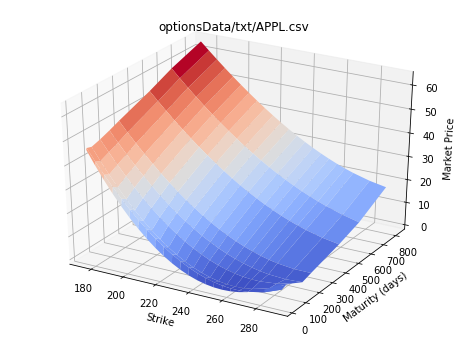

In [3]:
excel_file = 'optionsData/txt/APPL.csv'
maturities, strikes, callPrices, fig = myReadPlotOptionSurface.readNPlot(excel_file);

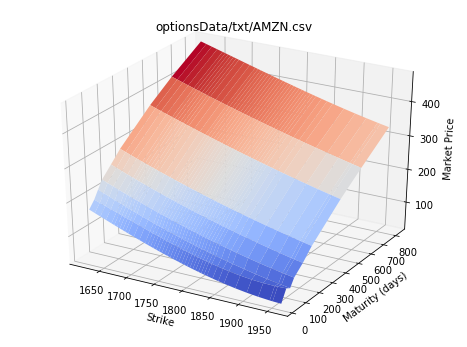

In [4]:
excel_file = 'optionsData/txt/AMZN.csv'
maturities, strikes, callPrices, fig = myReadPlotOptionSurface.readNPlot(excel_file);

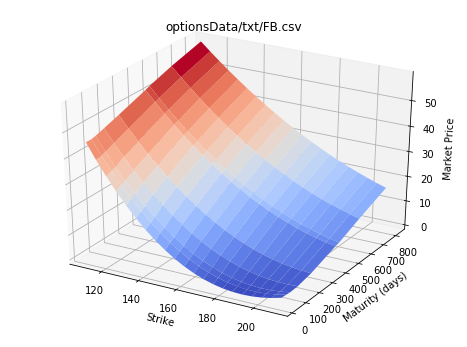

In [5]:
excel_file = 'optionsData/txt/FB.csv'
maturities, strikes, callPrices, fig = myReadPlotOptionSurface.readNPlot(excel_file);

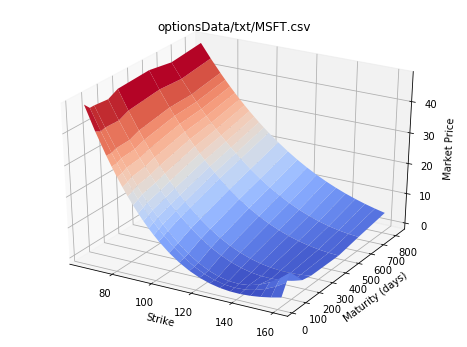

In [6]:
excel_file = 'optionsData/txt/MSFT.csv'
maturities, strikes, callPrices, fig = myReadPlotOptionSurface.readNPlot(excel_file);
# size of callPrices = num_T * num_K

### The following calibration is based on MSFT Call Options. You can switch to other options by using different $maturities, strikes, callPrices$.


# 1) Algorithm

In [8]:
# main function
def calibrate(market_data, model, method, objective_function, max_iter):
    opt_params, loss = method.my_optimize(market_data, model, objective_function)
    return opt_params, loss

In [44]:
# Method template
from scipy import optimize

class MyMethod:
    
    def __init__(self):
        self.progress = False; self.current_loops = 0; self.total_loops = 1
    
    def show_progress(self, total_loops):
        self.progress = True; self.total_loops = total_loops;
        print("GridSearchMethod requires: ",self.total_loops, "loops in total...")
        
    def reset_progress(self):
        self.progress = False; self.current_loops = 0; self.total_loops = 1;
        
    def loss_func(self, param, *variables):
        if(self.progress):
            self.current_loops += 1
            print("\r", "Current iteration: ", self.current_loops, "percentage: ", round(self.current_loops*100 / self.total_loops), "%", end="")
        market_data, model, objective_function = variables
        maturities, strikes, marketPrices = tuple(market_data)
        modelPrices = self.predict_price(param, (maturities, strikes), model)
        lenT, lenK = modelPrices.shape
        mae = 0
        for j in range(lenT):
            mae += objective_function(modelPrices[j,:], marketPrices[j,:])
        return mae
    
    def predict_price(self, param, market_data, model):
        maturities, strikes= tuple(market_data)
        lenT = len(maturities)
        lenK = len(strikes)

        modelPrices = np.zeros((lenT, lenK))
#         print(marketPrices.shape, modelPrices.shape)
        for j in range(lenT):
            T = maturities[j]
            #print tmp_params, T
            [km, cT_km] = model.genericFFT(param, strikes, T)
            modelPrices[j,:] = np.interp(np.log(strikes), km, cT_km)

        return modelPrices
         
class GridSearchMethod(MyMethod):
    def __init__(self, params_start, params_end, params_N):
        super().__init__()
        self.params_start = params_start
        self.params_end = params_end
        self.params_N = params_N
        
        
    def my_optimize(self,market_data, model, objective_function):

        rranges = tuple([slice(self.params_start[i], self.params_end[i], (self.params_end[i] -self.params_start[i]) / self.params_N[i]) for i in range(len(self.params_start))])
        self.show_progress(np.prod(self.params_N))
#         resbrute = optimize.brute(self.loss_func, rranges, args=(market_data, model, objective_function), full_output=True, finish=optimize.fmin)
        resbrute = optimize.brute(self.loss_func, rranges, args=(market_data, model, objective_function), full_output=True, finish=None)
        x0, fval, grid, Jout = resbrute
#         print(grid)
#         print(Jout)
        print()
        self.reset_progress()
        return x0,fval
    
class NelderMeadMethod(MyMethod):
    def __init__(self, params_start, iter_N):
        super().__init__()
        self.params_start = params_start
        self.iter_N = iter_N
        
        
    def my_optimize(self,market_data, model, objective_function):
        self.show_progress(2*self.iter_N)
        resbrute = fmin(\
        self.loss_func, \
        self.params_start, \
        args=(market_data, model, objective_function), \
        maxiter=self.iter_N,\
        maxfun=2*self.iter_N,\
        disp=True, \
        retall=False,\
        full_output=True)
    

        x0, fval, num_iter, funcalls, warnflags = resbrute

        print()
        self.reset_progress()
        return x0,fval
        
class BFGSMethod(MyMethod):
    def __init__(self, params_start, iter_N):
        super().__init__()
        self.params_start = params_start
        self.iter_N = iter_N
        
    def my_optimize(self,market_data, model, objective_function):
        self.show_progress(self.iter_N)
        resbrute = minimize(\
                self.loss_func,\
                self.params_start,\
                args=(market_data, model, objective_function), \
                method='BFGS', \
                options={'disp': True, 'maxiter':self.iter_N})
        
        x0, fval = resbrute.x, resbrute.fun
        print()
        self.reset_progress()
        return x0,fval

In [30]:
# Model template
class MyModel:
    
    def __init__(self, S0, r, q, alpha, eta, n): 

        self.S0 = S0; self.r = r; self.q = q; self.alpha = alpha; self.eta = eta; self.n = n
    
    def genericFFT(self, param, strikes, T):
        sig = param
        
        N = 2**self.n

        # step-size in log strike space
        lda = (2*np.pi/N)/self.eta

        #Choice of beta
        beta = np.log(np.mean(strikes))-N*lda/2
#         beta = np.log(k)

        # forming vector x and strikes km for m=1,...,N

        # discount factor
        df = np.exp(-self.r*T)

        nuJ = np.arange(N)*self.eta
        
        psi_nuJ = df*self.generic_CF(param, nuJ-(self.alpha+1)*1j, T)/((self.alpha + 1j*nuJ)*(self.alpha+1+1j*nuJ))
        
        j_vector = np.arange(N)
        km_vector = beta + j_vector * lda
        wJ_vector = np.repeat(self.eta, N)
        wJ_vector[0] = self.eta/2
        
        xX = np.exp(-1j*beta*nuJ)*psi_nuJ*wJ_vector
        yY = np.fft.fft(xX)

        multiplier = np.exp(-self.alpha*km_vector)/np.pi
        cT_km = multiplier*np.real(yY)

        return km_vector, cT_km
    
class MyGBMModel(MyModel):
    # params = [sig]
    def generic_CF(self,param, u,T):
#         print(param, u,T)
        sig = param
        mu = np.log(self.S0, dtype = complex) + (self.r-self.q-sig**2/2)*T
        a = sig*np.sqrt(T)
        phi = np.exp(1j*mu*u-(a*u)**2/2)
#         print(phi)
        return phi

class MyHestonModel(MyModel):
    
    # params = [kappa, theta, sigma, rho, v0]
    def generic_CF(self,param, u,T):
        
        kappa  = param[0];
        theta  = param[1];
        sigma  = param[2];
        rho    = param[3];
        v0     = param[4];

        tmp = (kappa-1j*rho*sigma*u);
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2);
        
        pow1 = 2*kappa*theta/(sigma**2);

        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*(self.r-self.q) + 1j*u*np.log(self.S0);
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2));
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp);
        log_phi = numer1 - log_denum1 - tmp2;
        phi = np.exp(log_phi);
        return phi
    
class MyVGModel(MyModel):
        # params = [sigma, nu, theta]
        
    def generic_CF(self,param, u,T):
        
        sigma  = param[0];
        nu     = param[1];
        theta  = param[2];

        if (nu == 0):
            mu = np.log(self.S0) + (self.r-self.q - theta -0.5*sigma**2)*T
            phi  = np.exp(1j*u*mu) * np.exp((1j*theta*u-0.5*sigma**2*u**2)*T)
        else:
            mu  = np.log(self.S0, dtype = complex) + (self.r-self.q + np.log(1-theta*nu-0.5*sigma**2*nu, dtype = complex)/nu)*T
            phi = np.exp(1j*u*mu, dtype = complex)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu))
        return phi

class MyVGSAModel(MyModel):
        # params = [kappa, theta, sigma, rho, nu, lambda, eta, y0]
        
    def phi_CIR(self, u_, T_, y0_, kappa_, eta_, lambda__):
            
        g_ = np.sqrt((kappa_**2)-2*lambda__**2*1j*u_);
        # A
        log_numer_A = kappa_**2*eta_*T_*lambda__**(-2)
        log_denum_A = 2*kappa_*eta_*lambda__**(-2)*np.log(np.cosh(0.5*g_*T_)+kappa_/g_*np.sinh(0.5*g_*T_), dtype = complex)
        log_A = log_numer_A - log_denum_A
        # B
        B = 2*1j*u_/(kappa_+g_/np.tanh(0.5*g_*T_))
        return np.exp(log_A+B*y0_)
        
    def phi_VG(self, u_, sigma_, nu_, theta_):
        return -1.0/nu_*np.log(1-1j*u_*theta_*nu_+0.5*sigma_**2*nu_*u_**2,dtype = complex)

    def generic_CF(self,param, u,T):
        
        kappa  = param[0];
        theta  = param[1];
        sigma  = param[2];
        rho    = param[3];
        nu     = param[4];
        lambda_ = param[5];
        eta    = param[6];
        y0     = param[7];

        tmp = (kappa-1j*rho*sigma*u);
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2);

        numer1 = np.exp(1j*u*np.log(self.S0)+(self.r-self.q)*T)
        Phi_VG_u = self.phi_VG(u,sigma,nu,theta)
        numer2 = self.phi_CIR(-1j*Phi_VG_u, T, nu, kappa, eta, lambda_)
        Phi_VG_1j = self.phi_VG(-1j,sigma,nu,theta)
        denum1 = np.power(self.phi_CIR(-1j*Phi_VG_1j, T, nu, kappa, eta, lambda_),1j*u,dtype = complex)
        phi = numer1*numer2/denum1
        return phi

    
class MyVGSSDModel(MyModel):
        # params = [sigma, nu, theta, gamma]
        
    def phi_Xt(self, u_, sigma_, nu_, theta_, gamma_, T_):
        base = 1.0 - 1j*u_*T_**gamma_*nu_*theta_ + 0.5*u_**2*T_**(2*gamma_)*nu_*sigma_**2
        return base**(-1.0/nu_)
        
    def generic_CF(self,param, u,T):
        
        sigma  = param[0];
        nu     = param[1];
        theta  = param[2];
        gamma  = param[3];
        
        numer1 = np.exp(1j*u*(np.log(self.S0)+(self.r-self.q)*T))
        numer2 = self.phi_Xt(u, sigma, nu, theta, gamma, T)
        denum1 = self.phi_Xt(-1j, sigma, nu, theta, gamma, T)
        phi = numer1*numer2/denum1
        return phi

In [11]:
# objective function template
def objective_L2(y, y_predicted):
    y_diff = np.array(y) - np.array(y_predicted)
    return np.sum(y_diff.T.dot(y_diff))

In [12]:
# two plotting helper functions
def plotPriceBySigma(strikes, maturities, sigma):
    lenK = len(strikes)
    lenT = len(maturities)
    predictedPrices = np.zeros((lenK, lenT))

    for i in range(lenT):
        T = maturities[i]
        [km, cT_km] = mgbm.genericFFT(sigma, strikes, T)
        predictedPrices[:,i] = np.interp(np.log(strikes), km, cT_km)

    fig = plt.figure(figsize=(12.,12.))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(maturities, strikes)
    ax.plot_surface(X, Y, predictedPrices)
    ax.set_xlabel('maturity T')
    ax.set_ylabel('strike K')
    ax.set_zlabel('call prices')
    ax.view_init(30, 150)
    plt.show()
#     print(predictedPrices)
    
def plotPriceByPrices(strikes, maturities, prices):
    X, Y = np.meshgrid(strikes, maturities)
    # plot the surface
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    #ax.plot_wireframe(X, Y, callPrices, rstride=1, cstride=1)
    ax.plot_surface(X, Y, prices, cmap=cm.coolwarm)
    # ax.plot_surface(X, Y, callPrices, cmap=cm.coolwarm)
    ax.set_ylabel('Maturity (days)') 
    ax.set_xlabel('Strike') 
    ax.set_zlabel('Market Price')
    plt.show()
#     print(prices)
    

# 2) Calibration

## 2.1) Grid Seach Method

### 2.1.1) test Heston Model

GridSearchMethod requires:  1024 loops in total...
 Current iteration:  1025 percentage:  100.0 %ercentage:  8.0 % 281 percentage:  27.0 % 407 percentage:  40.0 %
Time eclipse in seconds 52.81280517578125
Opt Param:  [ 2.875    0.06375  0.25    -0.675    0.055  ] Min Loss:  2238.8833302726434


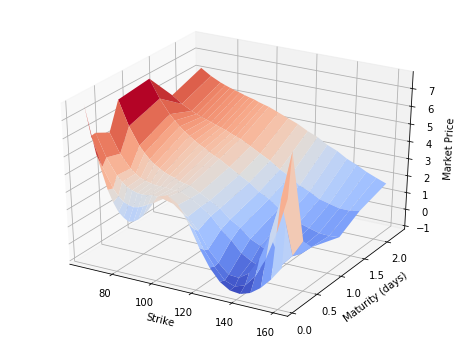

In [13]:
# test Heston Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
start = time.time()

mheston = MyHestonModel(S0, r, q, alpha, eta, n)
gridheston = GridSearchMethod([2.5,0.06,0.1,-0.675,0.04], [3.0,0.065,0.3,-0.625,0.06], [4,4,4,4,4])
grid_heston_opt_param, loss = calibrate((maturities, strikes, callPrices),mheston, gridheston ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds",end - start)
print("Opt Param: ", grid_heston_opt_param, "Min Loss: ", loss)
modelPrices = gridheston.predict_price(grid_heston_opt_param, (maturities, strikes), mheston)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

### 2.1.2) test GBM Model

GridSearchMethod requires:  10 loops in total...
 Current iteration:  11 percentage:  110.0 %
Time eclipse in seconds 0.20145797729492188
Opt Param:  0.32020000000000004 Min Loss:  1274.160769825591


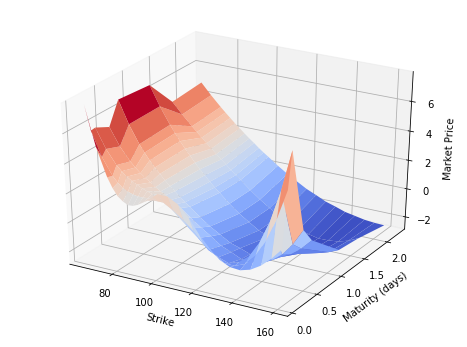

In [14]:
# test GBM Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12

start = time.time()

mgbm = MyGBMModel(S0, r, q, alpha, eta, n)
gridgbm = GridSearchMethod([0.001], [0.4], [10])
grid_gbm_opt_param, loss = calibrate((maturities, strikes, callPrices),mgbm, gridgbm ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds",end - start)
print("Opt Param: ", grid_gbm_opt_param, "Min Loss: ", loss)
modelPrices = gridgbm.predict_price(grid_gbm_opt_param, (maturities, strikes), mgbm)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

### 2.1.3) test VG Model

GridSearchMethod requires:  1000 loops in total...
 Current iteration:  1001 percentage:  100.0 %ercentage:  9.0 % 114 percentage:  11.0 % 25.0 % percentage:  27.0 %percentage:  84.0 %Current iteration:  859 percentage:  86.0 %Current iteration:  906 percentage:  91.0 % 962 percentage:  96.0 %99.0 %
Time eclipse in seconds 26.591732025146484
Opt Param:  [0.307 0.01  0.901] Min Loss:  1323.8884125818483


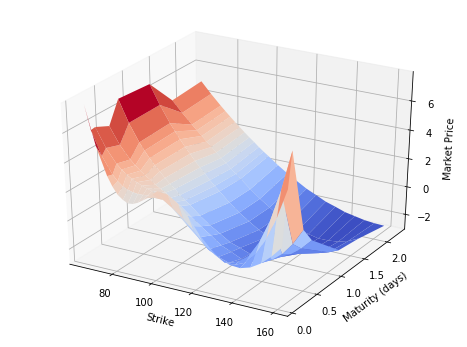

In [15]:
# test VG Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
import time
start = time.time()

mvg = MyVGModel(S0, r, q, alpha, eta, n)
gridvg = GridSearchMethod([0.01,0.01,0.01], [1,1,1], [10,10,10])
grid_vg_opt_param, loss = calibrate((maturities, strikes, callPrices),mvg, gridvg ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds", end - start)
print("Opt Param: ", grid_vg_opt_param, "Min Loss: ", loss)
modelPrices = gridvg.predict_price(grid_vg_opt_param, (maturities, strikes), mvg)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

### 2.1.4) test VGSA Model

GridSearchMethod requires:  6561 loops in total...
 Current iteration:  6562 percentage:  100.0 %ercentage:  0.0 % percentage:  1.0 % percentage:  1.0 %6.0 %Current iteration:  1249 percentage:  19.0 %1606 percentage:  24.0 %2828 percentage:  43.0 %% 3224 percentage:  49.0 %3761 percentage:  57.0 %%79.0 % %
Time eclipse in seconds 433.49324584007263
Opt Param:  [0.34 0.01 0.67 0.01 0.34 0.01 0.01 0.01] Min Loss:  1742.5665226563428


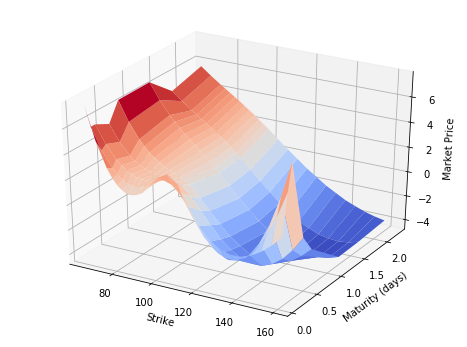

In [16]:
# test VGSA Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
import time
start = time.time()

mvgsa = MyVGSAModel(S0, r, q, alpha, eta, n)
gridvgsa = GridSearchMethod([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01], [1,1,1,1,1,1,1,1], [3,3,3,3,3,3,3,3])
# gridvgsa = GridSearchMethod([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01], [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1])
grid_vgsa_opt_param, loss = calibrate((maturities, strikes, callPrices),mvgsa, gridvgsa ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds", end - start)
print("Opt Param: ", grid_vgsa_opt_param, "Min Loss: ", loss)
modelPrices = gridvgsa.predict_price(grid_vgsa_opt_param, (maturities, strikes), mvgsa)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

#### This calibration takes a long time due to the curse of dimensionality. The domain of parameter set is of $R^8$. 

### 2.1.5) test VGSSD Model

GridSearchMethod requires:  625 loops in total...
 Current iteration:  626 percentage:  100.0 % % 86 percentage:  14.0 %480 percentage:  77.0 % percentage:  93.0 %
Time eclipse in seconds 15.346970796585083
Opt Param:  [0.208 0.01  0.01  0.604] Min Loss:  1355.7019065923635


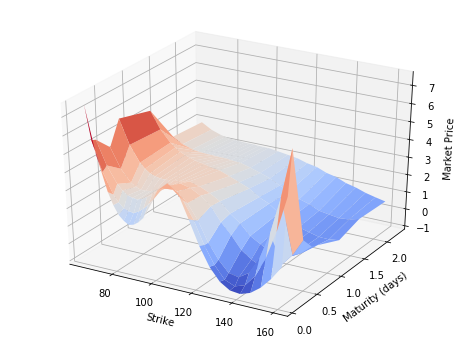

In [17]:
# test VGSSD Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
import time
start = time.time()

mvgssd = MyVGSSDModel(S0, r, q, alpha, eta, n)
gridvgssd = GridSearchMethod([0.01,0.01,0.01,0.01], [1,1,1,1], [5,5,5,5])
# gridvgsa = GridSearchMethod([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01], [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1])
grid_vgssd_opt_param, loss = calibrate((maturities, strikes, callPrices),mvgssd, gridvgssd ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds", end - start)
print("Opt Param: ", grid_vgssd_opt_param, "Min Loss: ", loss)
modelPrices = gridvgssd.predict_price(grid_vgssd_opt_param, (maturities, strikes), mvgssd)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

#### VGSSD proves to be the best fitting model so far.

## 2.2) Nelder-Mead Method
### We continue optimize using the result of our grid search method as starting points.

### 2.2.1) test Heston Model

GridSearchMethod requires:  800 loops in total...
 Current iteration:  648 percentage:  81 %Warning: Maximum number of iterations has been exceeded. %Current iteration:  500 percentage:  62 %

Time eclipse in seconds 28.657387733459473
Opt Param:  [-0.64188071 -0.11943812  1.95924708 -0.76026804  0.21639061] Min Loss:  499.9573189762124


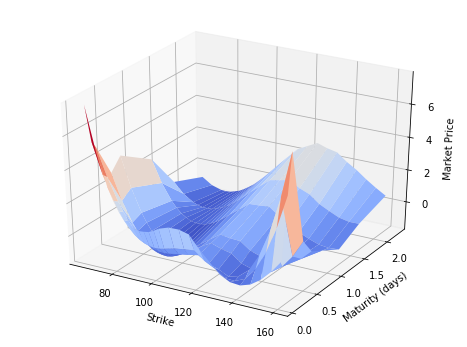

In [35]:
# test Heston Model
# params = [kappa, theta, sigma, rho, v0]
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
start = time.time()

mheston = MyHestonModel(S0, r, q, alpha, eta, n)
NMheston = NelderMeadMethod(grid_heston_opt_param, 400)
NM_heston_opt_param, loss = calibrate((maturities, strikes, callPrices),mheston, NMheston ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds",end - start)
print("Opt Param: ", NM_heston_opt_param, "Min Loss: ", loss)
modelPrices = NMheston.predict_price(NM_heston_opt_param, (maturities, strikes), mheston)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

#### Heston method fits the data very well.

### 2.2.2) test GBM Model

GridSearchMethod requires:  800 loops in total...
 Current iteration:  22 percentage:  3 %Optimization terminated successfully.
         Current function value: 1265.309977
         Iterations: 11
         Function evaluations: 22

Time eclipse in seconds 0.4328436851501465
Opt Param:  [0.32732945] Min Loss:  1265.3099765896902


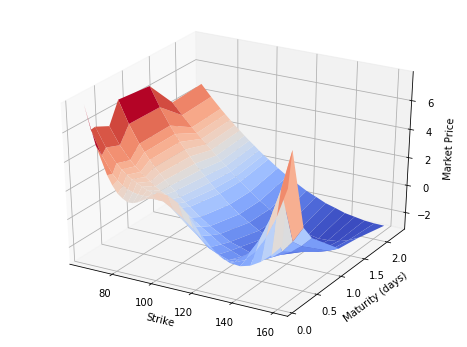

In [37]:
# test GBM Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12

start = time.time()

mgbm = MyGBMModel(S0, r, q, alpha, eta, n)
NMgbm = NelderMeadMethod(grid_gbm_opt_param, 400)
NM_gbm_opt_param, loss = calibrate((maturities, strikes, callPrices),mgbm, NMgbm ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds",end - start)
print("Opt Param: ", NM_gbm_opt_param, "Min Loss: ", loss)
modelPrices = NMgbm.predict_price(NM_gbm_opt_param, (maturities, strikes), mgbm)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

### 2.2.3) test VG Model

GridSearchMethod requires:  800 loops in total...
 Current iteration:  705 percentage:  88 %Warning: Maximum number of iterations has been exceeded.  614 percentage:  77 %

Time eclipse in seconds 19.442033767700195
Opt Param:  [ 0.32765074 -0.00531579  0.91829637] Min Loss:  1184.5112099736107


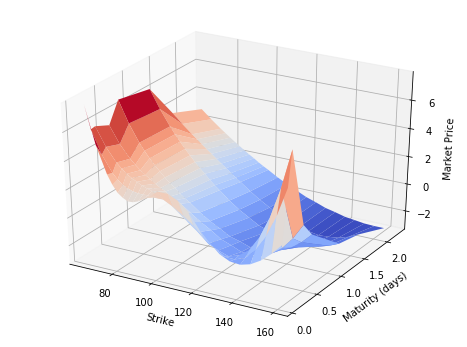

In [38]:
# test VG Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
import time
start = time.time()

mvg = MyVGModel(S0, r, q, alpha, eta, n)
NMvg = NelderMeadMethod(grid_vg_opt_param,400)
NM_vg_opt_param, loss = calibrate((maturities, strikes, callPrices),mvg, NMvg ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds", end - start)
print("Opt Param: ", NM_vg_opt_param, "Min Loss: ", loss)
modelPrices = NMvg.predict_price(NM_vg_opt_param, (maturities, strikes), mvg)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

### 2.2.4) test VGSA Model

GridSearchMethod requires:  800 loops in total...
 Current iteration:  607 percentage:  76 %Warning: Maximum number of iterations has been exceeded.

Time eclipse in seconds 44.67989635467529
Opt Param:  [-2.22841241 -0.40895068  0.89605327  0.20928553  0.1759603  -0.01341271
  0.17669941  0.07462765] Min Loss:  1270.345060409515


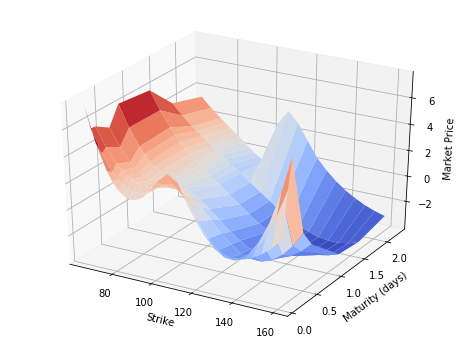

In [39]:
# test VGSA Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
import time
start = time.time()

mvgsa = MyVGSAModel(S0, r, q, alpha, eta, n)
NMvgsa = NelderMeadMethod(grid_vgsa_opt_param,400)
# gridvgsa = GridSearchMethod([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01], [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1])
NM_vgsa_opt_param, loss = calibrate((maturities, strikes, callPrices),mvgsa, NMvgsa ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds", end - start)
print("Opt Param: ", NM_vgsa_opt_param, "Min Loss: ", loss)
modelPrices = NMvgsa.predict_price(NM_vgsa_opt_param, (maturities, strikes), mvgsa)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

### 2.2.5) test VGSSD Model

GridSearchMethod requires:  400 loops in total...
 Current iteration:  354 percentage:  88 %Warning: Maximum number of iterations has been exceeded.

Time eclipse in seconds 8.672369003295898
Opt Param:  [ 0.24699184 -0.00546131  0.03356176  0.37129888] Min Loss:  349.9005511347541


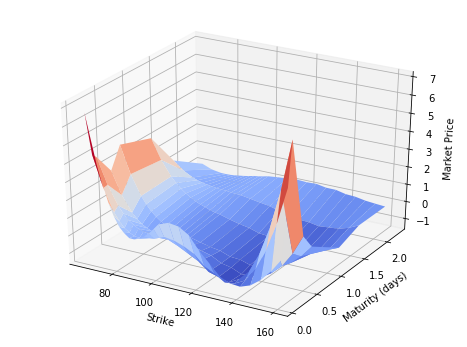

In [26]:
# test VGSSD Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
import time
start = time.time()

mvgssd = MyVGSSDModel(S0, r, q, alpha, eta, n)
NMvgssd = NelderMeadMethod(grid_vgssd_opt_param,400)
# gridvgsa = GridSearchMethod([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01], [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1])
NM_vgssd_opt_param, loss = calibrate((maturities, strikes, callPrices),mvgssd, NMvgssd ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds", end - start)
print("Opt Param: ", NM_vgssd_opt_param, "Min Loss: ", loss)
modelPrices = NMvgssd.predict_price(NM_vgssd_opt_param, (maturities, strikes), mvgssd)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

#### VGSSD fits the data well as usual.

## 2.3) Gradient Based Method (BFGS)

### 2.3.1) test Heston Model

GridSearchMethod requires:  200 loops in total...
 Current iteration:  821 percentage:  410 %ercentage:  32 % % 112 % percentage:  120 %223 %553 percentage:  276 % % percentage:  330 %Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 404.426932
         Iterations: 51
         Function evaluations: 821
         Gradient evaluations: 116

Time eclipse in seconds 41.899110555648804
Opt Param:  [-0.07816784 -3.76931776  3.5584478  -0.73372488  0.26884843] Min Loss:  404.4269319516357


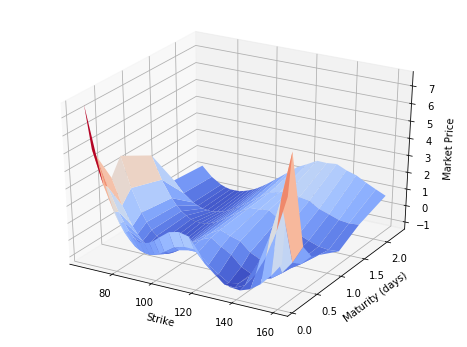

In [45]:
# test Heston Model
# params = [kappa, theta, sigma, rho, v0]
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
start = time.time()

mheston = MyHestonModel(S0, r, q, alpha, eta, n)
BFGSheston = BFGSMethod(NM_heston_opt_param, 200)
BFGS_heston_opt_param, loss = calibrate((maturities, strikes, callPrices),mheston, BFGSheston ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds",end - start)
print("Opt Param: ", BFGS_heston_opt_param, "Min Loss: ", loss)
modelPrices = BFGSheston.predict_price(BFGS_heston_opt_param, (maturities, strikes), mheston)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

### 2.3.2) test GBM Model

GridSearchMethod requires:  200 loops in total...
 Current iteration:  112 percentage:  56 %Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 1265.309973
         Iterations: 3
         Function evaluations: 112
         Gradient evaluations: 37

Time eclipse in seconds 2.4315013885498047
Opt Param:  [0.32733379] Min Loss:  1265.3099732782214


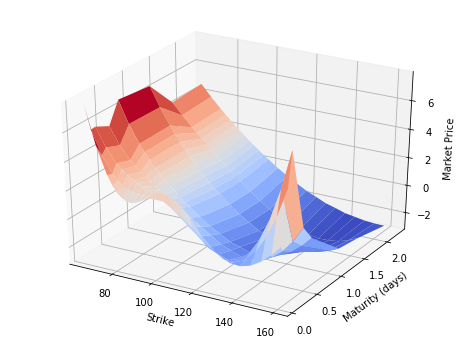

In [48]:
# test GBM Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12

start = time.time()

mgbm = MyGBMModel(S0, r, q, alpha, eta, n)
BFGSgbm = BFGSMethod(NM_gbm_opt_param, 200)
BFGS_gbm_opt_param, loss = calibrate((maturities, strikes, callPrices),mgbm, BFGSgbm ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds",end - start)
print("Opt Param: ", BFGS_gbm_opt_param, "Min Loss: ", loss)
modelPrices = BFGSgbm.predict_price(BFGS_gbm_opt_param, (maturities, strikes), mgbm)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

### 2.3.3) test VG Model

GridSearchMethod requires:  400 loops in total...
 Current iteration:  37 percentage:  9 %9 %Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 1184.511210
         Iterations: 0
         Function evaluations: 37
         Gradient evaluations: 5

Time eclipse in seconds 1.1250007152557373
Opt Param:  [ 0.32765074 -0.00531579  0.91829637] Min Loss:  1184.5112099736107


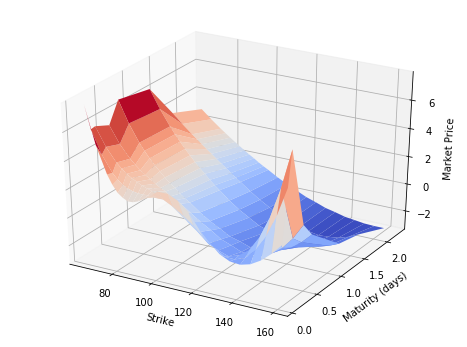

In [47]:
# test VG Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
import time
start = time.time()

mvg = MyVGModel(S0, r, q, alpha, eta, n)
BFGSvg = BFGSMethod(NM_vg_opt_param,400)
BFGS_vg_opt_param, loss = calibrate((maturities, strikes, callPrices),mvg, BFGSvg ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds", end - start)
print("Opt Param: ", BFGS_vg_opt_param, "Min Loss: ", loss)
modelPrices = BFGSvg.predict_price(BFGS_vg_opt_param, (maturities, strikes), mvg)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

### 2.3.4) test VGSA Model

GridSearchMethod requires:  400 loops in total...
 Current iteration:  1161 percentage:  290 %centage:  22 % 24 %percentage:  76 %346 percentage:  86 %%142 %Current iteration:  824 percentage:  206 %Current iteration:  847 percentage:  212 % 233 % %Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 1261.589843
         Iterations: 21
         Function evaluations: 1161
         Gradient evaluations: 115

Time eclipse in seconds 84.20687651634216
Opt Param:  [-2.28719248 -0.35752699  0.85045402  0.20928553  0.18843741 -0.01268095
  0.18910844  0.07462765] Min Loss:  1261.5898432741108


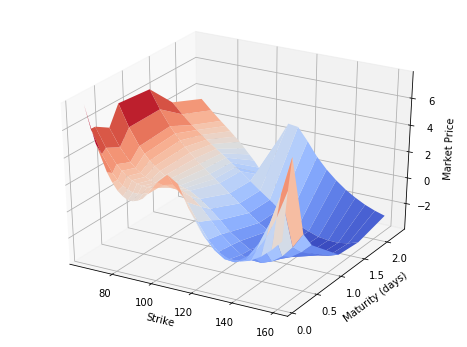

In [49]:
# test VGSA Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
import time
start = time.time()

mvgsa = MyVGSAModel(S0, r, q, alpha, eta, n)
BFGSvgsa = BFGSMethod(NM_vgsa_opt_param,400)
# gridvgsa = GridSearchMethod([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01], [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1])
BFGS_vgsa_opt_param, loss = calibrate((maturities, strikes, callPrices),mvgsa, BFGSvgsa ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds", end - start)
print("Opt Param: ", BFGS_vgsa_opt_param, "Min Loss: ", loss)
modelPrices = BFGSvgsa.predict_price(BFGS_vgsa_opt_param, (maturities, strikes), mvgsa)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

### 2.3.5) test VGSSD Model

GridSearchMethod requires:  400 loops in total...
 Current iteration:  914 percentage:  228 %Warning: Desired error not necessarily achieved due to precision loss.
         Current function value: 279.397513
         Iterations: 24
         Function evaluations: 914
         Gradient evaluations: 150

Time eclipse in seconds 22.72026300430298
Opt Param:  [0.21075327 0.08491503 0.06273741 0.4066907 ] Min Loss:  279.3975127922616


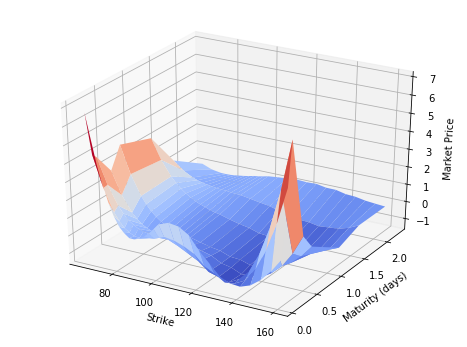

In [50]:
# test VGSSD Model
# #Contract Parameters
S0 = 105.70
K = 80
k = np.log(K)
r = 0.0237
q = 0.017

# FFT Parameters
alpha = 1.5
eta = 0.02

n = 12
import time
start = time.time()

mvgssd = MyVGSSDModel(S0, r, q, alpha, eta, n)
BFGSvgssd = BFGSMethod(NM_vgssd_opt_param,400)
# gridvgsa = GridSearchMethod([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01], [1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1])
BFGS_vgssd_opt_param, loss = calibrate((maturities, strikes, callPrices),mvgssd, BFGSvgssd ,objective_L2, 1)
end = time.time()
print("Time eclipse in seconds", end - start)
print("Opt Param: ", BFGS_vgssd_opt_param, "Min Loss: ", loss)
modelPrices = BFGSvgssd.predict_price(NM_vgssd_opt_param, (maturities, strikes), mvgssd)
plotPriceByPrices(strikes, maturities, callPrices - modelPrices)

# 3) Conclusion

### In this project, several combinations of base models and optimization methods are tested based on MSFT Call Option prices. Comparing both accuracy, we can conclude that both heston model and vgssd model fit the data very well. In therms of efficiency, the Nelder Mead Method proves to be least computational heavy while Grid Search Method serves a good pivot algorithm to find a good starting point. The calibrations above can be gneralized to fit other price data by using different data sources. The answer to the question of the best model may be unique due to specific data.